In [ ]:
#!pip install mlflow

In [70]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [71]:
# load dataset
dataset = pd.read_csv("london_weather.csv")

# show first 5 rows
print(dataset.head(5))

# show info
print(dataset.info())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341

In [72]:
# Converting 'date' column to datetime format
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y%m%d")
print(dataset)

# Check missing values
print(dataset.isna().sum())
print(len(dataset))

            date  cloud_cover  sunshine  global_radiation  max_temp  \
0     1979-01-01          2.0       7.0              52.0       2.3   
1     1979-01-02          6.0       1.7              27.0       1.6   
2     1979-01-03          5.0       0.0              13.0       1.3   
3     1979-01-04          8.0       0.0              13.0      -0.3   
4     1979-01-05          6.0       2.0              29.0       5.6   
...          ...          ...       ...               ...       ...   
15336 2020-12-27          1.0       0.9              32.0       7.5   
15337 2020-12-28          7.0       3.7              38.0       3.6   
15338 2020-12-29          7.0       0.0              21.0       4.1   
15339 2020-12-30          6.0       0.4              22.0       5.6   
15340 2020-12-31          7.0       1.3              34.0       1.5   

       mean_temp  min_temp  precipitation  pressure  snow_depth  
0           -4.1      -7.5            0.4  101900.0         9.0  
1           -2.

     year  month                date  cloud_cover  sunshine  global_radiation  \
0    1979      1 1979-01-16 00:00:00     5.724138  1.887097         29.032258   
1    1979      2 1979-02-14 12:00:00     6.360000  1.889286         45.214286   
2    1979      3 1979-03-16 00:00:00     5.967742  3.212903         93.354839   
3    1979      4 1979-04-15 12:00:00     6.133333  3.543333        134.166667   
4    1979      5 1979-05-16 00:00:00     5.290323  6.470968        204.064516   
..    ...    ...                 ...          ...       ...               ...   
499  2020      8 2020-08-16 00:00:00     5.000000  6.135484        210.741935   
500  2020      9 2020-09-15 12:00:00     4.200000  6.540000        170.000000   
501  2020     10 2020-10-16 00:00:00     5.774194  1.887097         72.516129   
502  2020     11 2020-11-15 12:00:00     5.933333  1.716667         43.166667   
503  2020     12 2020-12-16 00:00:00     5.466667  1.425806         27.967742   

      max_temp  mean_temp  

<Axes: xlabel='year', ylabel='mean_temp'>

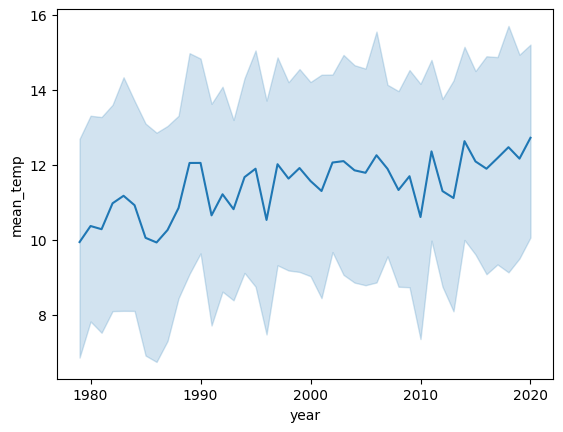

In [73]:
# Grouping data by year and month, calculating mean of weather metrics
dataset['year'] = dataset['date'].dt.year
dataset['month'] = dataset['date'].dt.month

dataset_per_month = dataset.groupby(['year', 'month'], as_index=False).mean()
print(dataset_per_month)

# Visualizing mean temperature
sns.lineplot(x="year", y="mean_temp", data=dataset_per_month)

<Axes: xlabel='month', ylabel='sunshine'>

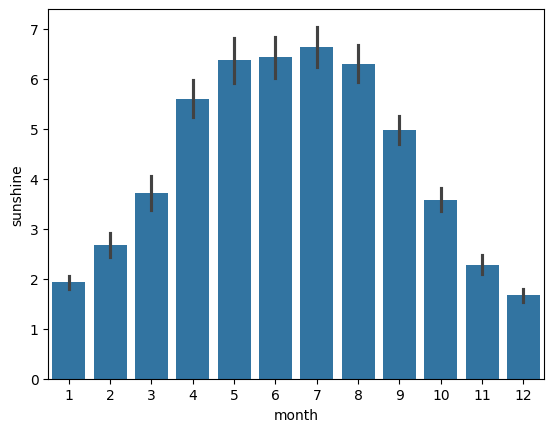

In [74]:
# Visualizing mean sunshine
sns.barplot(x="month", y="sunshine", data=dataset_per_month)

<Axes: >

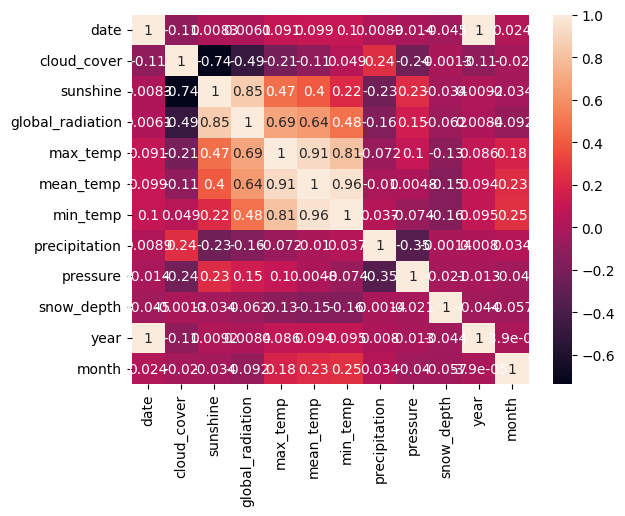

In [75]:
# Visualizing heatmap of correlation
sns.heatmap(dataset.corr(), annot=True)

In [76]:
# Updating dataset with relevant columns
relevant_columns = ["cloud_cover", "sunshine", "global_radiation", "snow_depth", "month", "mean_temp"]
dataset = dataset[relevant_columns]
print(dataset)

       cloud_cover  sunshine  global_radiation  snow_depth  month  mean_temp
0              2.0       7.0              52.0         9.0      1       -4.1
1              6.0       1.7              27.0         8.0      1       -2.6
2              5.0       0.0              13.0         4.0      1       -2.8
3              8.0       0.0              13.0         2.0      1       -2.6
4              6.0       2.0              29.0         1.0      1       -0.8
...            ...       ...               ...         ...    ...        ...
15336          1.0       0.9              32.0         NaN     12        7.5
15337          7.0       3.7              38.0         NaN     12        1.1
15338          7.0       0.0              21.0         NaN     12        2.6
15339          6.0       0.4              22.0         NaN     12        2.7
15340          7.0       1.3              34.0         NaN     12       -0.8

[15341 rows x 6 columns]


In [77]:
# preprocess data, fill in missing values, scale values
def preprocess_dataset(dataset, feature_selection, target_var):
    dataset = dataset.dropna(subset=[target_var])
    X = dataset[feature_selection]
    y = dataset[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test  = imputer.transform(X_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

feature_selection = ['month', 'cloud_cover', 'sunshine', 'global_radiation', 'snow_depth']
target_var = 'mean_temp'
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, feature_selection, target_var)

In [ ]:
# This is just sample code for creating an experiment with MLflow
mlflow.create_experiment('Experiment 1')

with mlflow.start_run():
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred, squared=False)

    # Log hyperparameters and metrics
    mlflow.set_experiment_tag("model", "decision tree")
    mlflow.log_metric("mse", mse)

    # Save the model
    mlflow.sklearn.log_model(model, "model")

In [38]:
# Define experiment name
EXPERIMENT_NAME = 'Regression v1'
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

# Setup for loop
for idx, depth in enumerate([1,2,5,10,20]):
    parameters = {
        'max_depth': depth,
        'random_state': 1
    }

    RUN_NAME = f"run_{idx}"

    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME):
        dreg = DecisionTreeRegressor(**parameters).fit(X_train, y_train)
        rfreg = RandomForestRegressor(**parameters).fit(X_train, y_train)

        dreg_pred = dreg.predict(X_test)
        rfreg_pred = rfreg.predict(X_test)

        dreg_r2 = r2_score(y_test, dreg_pred)
        rfreg_r2 = r2_score(y_test, rfreg_pred)

        # Save experiment results
        mlflow.log_param("max_depth", depth)

        mlflow.log_metric("dreg_r2", dreg_r2)
        mlflow.log_metric("rfreg_r2", rfreg_r2)


In [78]:
mlflow.search_runs(experiment_names=["Regression v1"])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.dreg_r2,metrics.rfreg_r2,params.max_depth,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName
0,1058a4bdad8744cabeaf1772492b76a9,844800980881510049,FINISHED,file:///content/mlruns/844800980881510049/1058...,2024-05-23 21:48:57.635000+00:00,2024-05-23 21:49:00.713000+00:00,0.609961,0.740943,20,LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...,root,run_4
1,5e9d490794c647ba886f63996663ed63,844800980881510049,FINISHED,file:///content/mlruns/844800980881510049/5e9d...,2024-05-23 21:48:55.945000+00:00,2024-05-23 21:48:57.629000+00:00,0.741046,0.768281,10,LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...,root,run_3
2,777f88869c9b491983033e42d6ac23ff,844800980881510049,FINISHED,file:///content/mlruns/844800980881510049/777f...,2024-05-23 21:48:55.130000+00:00,2024-05-23 21:48:55.941000+00:00,0.731995,0.742707,5,LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...,root,run_2
3,df0ad41ee250485dbe29aaf934e375c9,844800980881510049,FINISHED,file:///content/mlruns/844800980881510049/df0a...,2024-05-23 21:48:54.665000+00:00,2024-05-23 21:48:55.127000+00:00,0.535798,0.554477,2,LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...,root,run_1
4,380c9372a53840ab8a3d54f2496f316a,844800980881510049,FINISHED,file:///content/mlruns/844800980881510049/380c...,2024-05-23 21:48:54.340000+00:00,2024-05-23 21:48:54.662000+00:00,0.316893,0.332191,1,LOCAL,/usr/local/lib/python3.10/dist-packages/colab_...,root,run_0
